In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sympy.utilities.iterables import variations
import time
from matplotlib.ticker import PercentFormatter
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")
#%matplotlib inline
%matplotlib widget

In [2]:
# GLOBAL CONSTANTS
J=-1
h=0
K=2

# Self-Avoiding walk

## All functions

In [79]:
'''NTS: THIS FUNCTION IS NO LONGER USED'''
def generate_walk(steps):
    # Initialize a walk with the starting point at the origin
    walk = [(0, 0, 0)]
    directions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
    # Perform the walk
    while len(walk) < steps:
        # Get the current position
        current_position = walk[-1]
        # Shuffle the directions to choose a random direction to move
        np.random.shuffle(directions)
        # Try each direction until we find a valid move
        move_found = False
        for direction in directions:
            new_position = tuple(current_position[i] + direction[i] for i in range(3))
            if new_position not in walk:
                walk.append(new_position)
                move_found = True
                break      
        # If no valid move is found, terminate the walk
        if not move_found:
            break
    return walk

In [3]:
def saw_3d(n):  
    x, y, z = [n], [n], [n]
    positions = set([(n,n,n)])  #positions is a set that stores all sites visited by the walk
    #stuck = False
    for i in range(n-1):
        directions = [(1, 0, 0), (-1, 0, 0), (0, 1, 0), (0, -1, 0), (0, 0, 1), (0, 0, -1)]
        directions_feasible = []  #directions_feasible stores the available directions 
        for dx, dy, dz in directions:
            if (x[-1] + dx, y[-1] + dy, z[-1]+dz) not in positions:  #checks if direction leads to a site not visited before
                directions_feasible.append((dx,dy,dz))
        if directions_feasible:  #checks if there is a direction available
            dx, dy,dz = directions_feasible[np.random.randint(0,len(directions_feasible))]  #choose a direction at random among available ones
            positions.add((x[-1] + dx, y[-1] + dy,z[-1]+dz))
            x.append(x[-1] + dx)
            y.append(y[-1] + dy)
            z.append(z[-1] + dz)
        else:  #in that case the walk is stuck
            #stuck = True
            #steps = i+1
            break  #terminate the walk prematurely
        #steps = n+1
    #print(positions)
    return x, y, z #, stuck, steps

In [4]:
def create_initial(rows, cols,height):
    return np.random.choice((-1,1), size=(rows,cols,height))

In [5]:
def merge_lists(x,y,z):
    return [[x[i],y[i],z[i]] for i in range(len(x))]

In [6]:
def spin_on_saw(spin_array,x,y,z):
    spins_list = merge_lists(x,y,z)
    for i in range(len(spin_array)):
        for j in range(len(spin_array[i])):
            for k in range(len(spin_array[i][j])):
                if [i,j,k] not in spins_list:
                    spin_array[i][j][k] = 0
    return spin_array

In [7]:
def plus_min(spin_array):
    plus_spin = []
    min_spin = []
    for i in range(len(spin_array)):
        for j in range(len(spin_array)):
            for k in range(len(spin_array)):
                if spin_array[i][j][k] == 1:
                    plus_spin.append([i,j,k])
                if spin_array[i][j][k] == -1:
                    min_spin.append([i,j,k])
    return plus_spin, min_spin

In [8]:
def neighbors(spin_array,N,x,y,z):
    left   = (x, (y-1),z)
    right  = (x, (y+1),z)
    top    = ((x-1), y,z)
    bottom = ((x+1), y,z)
    under = (x,y,z-1)
    over = (x,y,z+1)
    '''left   = (x, (y+1+N)%N)
    right  = (x, (y-1+N)%N)
    top    = ((x+1+N)%N, y)
    bottom = ((x-1+N)%N, y)'''
    return [spin_array[left[0], left[1],left[2]],
            spin_array[right[0], right[1],right[2]],
            spin_array[top[0], top[1], top[2]],
            spin_array[bottom[0], bottom[1], bottom[2]],
            spin_array[over[0], over[1], over[2]],
            spin_array[under[0], under[1], under[2]]
           ]

In [9]:
def energy(spin_array, N, x_pos ,y_pos,z_pos):
    return (J*spin_array[x_pos][y_pos][z_pos]*sum(neighbors(spin_array, N, x_pos, y_pos,z_pos)) + h*spin_array[x_pos][y_pos][z_pos])

In [10]:
def total_energy(spin_array,N,x,y,z):
    spin_list = merge_lists(x,y,z)
    '''sum_energy = 0
    for i in range(len(spin_list)):
        print("position: ",spin_list[i][0],spin_list[i][1])
        print("neighbours: ", neighbors(spin_array, N, spin_list[i][0], spin_list[i][1]))
        print("energy:",energy(spin_array,N, spin_list[i][0], spin_list[i][1]))
    print(K*len(x))'''
    return -(sum([energy(spin_array,N, spin_list[i][0], spin_list[i][1], spin_list[i][2]) for i in range(len(spin_list))]) + K*len(x))

### Functions for the SAW moves 

In [11]:
def free_list(positions_list, spin_array):
    for i in range(len(positions_list)-1,-1,-1):
        #print(positions_list)
        if not (spin_array[positions_list[i][0]][positions_list[i][1]][positions_list[i][2]] == 0):
            positions_list.remove(positions_list[i])
    return positions_list

In [12]:
def endpoints(x,y,z,i,spin_array):
    if i==0:
        if x[1] == x[0]+1 and y[1]==y[0] and z[1] == z[0]:               #1
            pos_pos =free_list([[x[i]+1,y[i]+1,z[i]],[x[i]+1,y[i]-1,z[i]],[x[i]+1,y[i],z[i]+1], [x[i]+1,y[i],z[i]-1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[1] == x[0] and y[1]==y[0]+1 and z[1]==z[0]:                #2
            pos_pos = free_list([[x[i]-1,y[i]+1,z[i]],[x[i],y[i]+1,z[i]-1],[x[i],y[i]+1,z[i]+1],[x[i]+1,y[i]+1,z[i]]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[1] == x[0]-1 and y[1]==y[0] and z[1]==z[0]:                #3
            pos_pos = free_list([[x[i]-1,y[i]+1,z[i]],[x[i]-1,y[i]-1,z[i]],[x[i]-1,y[i],z[i]-1], [x[i]-1,y[i],z[i]+1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[1] == x[0] and y[1]==y[0]-1 and z[1]==z[0]:                #4
            pos_pos = free_list([[x[i]-1,y[i]-1,z[i]],[x[i],y[i]-1,z[i]-1],[x[i],y[i]-1,z[i]+1],[x[i]+1,y[i]-1,z[i]]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[1] == x[0] and y[1]==y[0] and z[1] == z[0]-1:
            pos_pos = free_list([[x[i]+1,y[i],z[i]-1],[x[i],y[i]+1,z[i]-1],[x[i]-1,y[i],z[i]-1],[x[i],y[i]-1,z[i]-1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[1] == x[0] and y[1]==y[0] and z[1] == z[0]+1:
            pos_pos = free_list([[x[i]+1,y[i],z[i]+1],[x[i],y[i]+1,z[i]+1],[x[i]-1,y[i],z[i]+1],[x[i],y[i]-1,z[i]+1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
    if i==len(x)-1:
        if x[i] == x[i-1]+1 and y[i]==y[i-1] and z[i] == z[i-1]:               #1
            pos_pos =free_list([[x[i]+1,y[i]+1,z[i]],[x[i]+1,y[i]-1,z[i]],[x[i]+1,y[i],z[i]+1], [x[i]+1,y[i],z[i]-1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[i] == x[i-1] and y[i]==y[i-1]+1 and z[i]==z[i-1]:                #2
            pos_pos = free_list([[x[i]-1,y[i]+1,z[i]],[x[i],y[i]+1,z[i]-1],[x[i],y[i]+1,z[i]+1],[x[i]+1,y[i]+1,z[i]]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[i] == x[i-1]-1 and y[i]==y[i-1] and z[i]==z[i-1]:                #3
            pos_pos = free_list([[x[i]-1,y[i]+1,z[i]],[x[i]-1,y[i]-1,z[i]],[x[i]-1,y[i],z[i]-1], [x[i]-1,y[i],z[i]+1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[i] == x[i-1] and y[i]==y[i-1]-1 and z[i]==z[i-1]:                #4
            pos_pos = free_list([[x[i]-1,y[i]-1,z[i]],[x[i],y[i]-1,z[i]-1],[x[i],y[i]-1,z[i]+1],[x[i]+1,y[i]-1,z[i]]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[i] == x[i-1] and y[i]==y[i-1] and z[i] == z[i-1]-1:
            pos_pos = free_list([[x[i]+1,y[i],z[i]-1],[x[i],y[i]+1,z[i]-1],[x[i]-1,y[i],z[i]-1],[x[i],y[i]-1,z[i]-1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
        if x[i] == x[i-1] and y[i]==y[i-1] and z[i] == z[i-1]+1:
            pos_pos = free_list([[x[i]+1,y[i],z[i]+1],[x[i],y[i]+1,z[i]+1],[x[i]-1,y[i],z[i]+1],[x[i],y[i]-1,z[i]+1]], spin_array)
            if len(pos_pos) != 0:
                j = np.random.randint(0,len(pos_pos))
                return pos_pos[j]
    return []

In [13]:
def correct_z(x,y,z,i,spin_array):
    possible = False
    positions = []
    if i == 0 and z[i] == z[i+1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    elif i == len(z)-1 and z[i] == z[i-1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    if z[i] == z[i+1] == z[i-1]:
        if y[i]+1 == y[i-1] and x[i] == x[i-1] and y[i+1] == y[i] and x[i]+1 == x[i+1] and spin_array[x[i]+1][y[i]+1][z[i]] ==0: #1
            positions = [x[i]+1,y[i]+1,z[i]]
            possible = True 
            
        if y[i] == y[i-1] and x[i]-1 == x[i-1] and y[i+1] == y[i]-1 and x[i] == x[i+1] and spin_array[x[i]-1][y[i]-1][z[i]] ==0: #2
            positions = [x[i]-1,y[i]-1,z[i]]
            possible = True
           
        if y[i] == y[i-1] and x[i]+1 == x[i-1] and y[i+1] == y[i]+1 and x[i] == x[i+1] and spin_array[x[i]+1][y[i]+1][z[i]] ==0: #3
            positions = [x[i]+1,y[i]+1,z[i]]
            possible = True
            
        if y[i]-1 == y[i-1] and x[i] == x[i-1] and y[i+1] == y[i] and x[i]-1 == x[i+1] and spin_array[x[i]-1][y[i]-1][z[i]] ==0: #4
            positions = [x[i]-1,y[i]-1,z[i]]
            possible = True
            
        if y[i] == y[i-1] and x[i]+1 == x[i-1] and y[i+1] == y[i]-1 and x[i]== x[i+1] and spin_array[x[i]+1][y[i]-1][z[i]] ==0: #5
            positions = [x[i]+1,y[i]-1,z[i]]
            possible = True
            return possible, positions
        if y[i]+1 == y[i-1] and x[i] == x[i-1] and y[i+1] == y[i] and x[i]-1== x[i+1] and spin_array[x[i]-1][y[i]+1][z[i]] ==0: #6
            positions = [x[i]-1,y[i]+1,z[i]]
            possible = True
            
        if y[i]-1 == y[i-1] and x[i] == x[i-1] and y[i+1] == y[i] and x[i]+1== x[i+1] and spin_array[x[i]+1][y[i]-1][z[i]] ==0: #7
            positions = [x[i]+1,y[i]-1,z[i]]
            possible = True
            
        if y[i] == y[i-1] and x[i]-1 == x[i-1] and y[i+1] == y[i]+1 and x[i]== x[i+1] and spin_array[x[i]-1][y[i]+1][z[i]] ==0: #8
            positions = [x[i]-1,y[i]+1,z[i]]
            possible = True
        return possible, positions
    else:
        return possible,positions

In [14]:
def correct_y(x,y,z,i,spin_array):
    possible = False
    positions = []
    if i == 0 and y[i] == y[i+1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    elif i == len(y)-1 and y[i] == y[i-1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    if y[i] == y[i+1] == y[i-1]:
        if z[i]+1 == z[i-1] and x[i] == x[i-1] and z[i+1] == z[i] and x[i]+1 == x[i+1] and spin_array[x[i]+1][y[i]][z[i]+1] ==0: #1
            positions = [x[i]+1,y[i],z[i]+1]
            possible = True 
            
        if z[i] == z[i-1] and x[i]-1 == x[i-1] and z[i+1] == z[i]-1 and x[i] == x[i+1] and spin_array[x[i]-1][y[i]][z[i]-1] ==0: #2
            positions = [x[i]-1,y[i],z[i]-1]
            possible = True
           
        if z[i] == z[i-1] and x[i]+1 == x[i-1] and z[i+1] == z[i]+1 and x[i] == x[i+1] and spin_array[x[i]+1][y[i]][z[i]+1] ==0: #3
            positions = [x[i]+1,y[i],z[i]+1]
            possible = True
            
        if z[i]-1 == z[i-1] and x[i] == x[i-1] and z[i+1] == z[i] and x[i]-1 == x[i+1] and spin_array[x[i]-1][y[i]][z[i]-1] ==0: #4
            positions = [x[i]-1,y[i],z[i]-1]
            possible = True
            
        if z[i] == z[i-1] and x[i]+1 == x[i-1] and z[i+1] == z[i]-1 and x[i]== x[i+1] and spin_array[x[i]+1][y[i]][z[i]-1] ==0: #5
            positions = [x[i]+1,y[i],z[i]-1]
            possible = True
            return possible, positions
        if z[i]+1 == z[i-1] and x[i] == x[i-1] and z[i+1] == z[i] and x[i]-1== x[i+1] and spin_array[x[i]-1][y[i]][z[i]+1] ==0: #6
            positions = [x[i]-1,y[i],z[i]+1]
            possible = True
            
        if z[i]-1 == z[i-1] and x[i] == x[i-1] and z[i+1] == z[i] and x[i]+1== x[i+1] and spin_array[x[i]+1][y[i]][z[i]-1] ==0: #7
            positions = [x[i]+1,y[i],z[i]-1]
            possible = True
            
        if z[i] == z[i-1] and x[i]-1 == x[i-1] and z[i+1] == z[i]+1 and x[i]== x[i+1] and spin_array[x[i]-1][y[i]][z[i]+1] ==0: #8
            positions = [x[i]-1,y[i],z[i]+1]
            possible = True
        return possible, positions
    else:
        return possible,positions

In [15]:
def correct_x(x,y,z,i,spin_array):
    possible = False
    positions = []
    if i == 0 and x[i] == x[i+1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    elif i == len(x)-1 and x[i] == x[i-1]:
        positions = endpoints(x,y,z,i,spin_array)
        if len(positions)!=0:
            possible = True
        return possible, positions
    if x[i] == x[i+1] == x[i-1]:
        if y[i]+1 == y[i-1] and z[i] == z[i-1] and y[i+1] == y[i] and z[i]+1 == z[i+1] and spin_array[x[i]][y[i]+1][z[i]+1] ==0: #1
            positions = [x[i],y[i]+1,z[i]+1]
            possible = True 
            
        if y[i] == y[i-1] and z[i]-1 == z[i-1] and y[i+1] == y[i]-1 and z[i] == z[i+1] and spin_array[x[i]][y[i]-1][z[i]-1] ==0: #2
            positions = [x[i],y[i]-1,z[i]-1]
            possible = True
           
        if y[i] == y[i-1] and z[i]+1 == z[i-1] and y[i+1] == y[i]+1 and z[i] == z[i+1] and spin_array[x[i]][y[i]+1][z[i]+1] ==0: #3
            positions = [x[i],y[i]+1,z[i]+1]
            possible = True
            
        if y[i]-1 == y[i-1] and z[i] == z[i-1] and y[i+1] == y[i] and z[i]-1 == z[i+1] and spin_array[x[i]][y[i]-1][z[i]-1] ==0: #4
            positions = [x[i],y[i]-1, z[i]-1]
            possible = True
            
        if y[i] == y[i-1] and z[i]+1 == z[i-1] and y[i+1] == y[i]-1 and z[i]== z[i+1] and spin_array[x[i]][y[i]-1][z[i]+1] ==0: #5
            positions = [x[i],y[i]-1,z[i]+1]
            possible = True
            return possible, positions
        if y[i]+1 == y[i-1] and z[i] == z[i-1] and y[i+1] == y[i] and z[i]-1== z[i+1] and spin_array[x[i]][y[i]+1][z[i]-1] ==0: #6
            positions = [x[i],y[i]+1, z[i]-1]
            possible = True
            
        if y[i]-1 == y[i-1] and z[i] == z[i-1] and y[i+1] == y[i] and z[i]+1== z[i+1] and spin_array[x[i]][y[i]-1][z[i]+1] ==0: #7
            positions = [x[i],y[i]-1, z[i]+1]
            possible = True
            
        if y[i] == y[i-1] and z[i]-1 == z[i-1] and y[i+1] == y[i]+1 and z[i]== z[i+1] and spin_array[x[i]][y[i]+1][z[i]-1] ==0: #8
            positions = [x[i],y[i]+1, z[i]-1]
            possible = True
        return possible, positions
    else:
        return possible,positions

In [17]:
def find_possible_points(x,y,z,spins):
    possible_points_x = []
    possible_points_y = []
    possible_points_z = []
    for i in range(0,len(x)-2):
        possible_x, positions_x = correct_x(x,y,z,i,spins)
        possible_y, positions_y = correct_y(x,y,z,i,spins)
        possible_z, positions_z = correct_z(x,y,z,i,spins)
        if possible_x:
            possible_points_x.append(i) #test: [x[i],y[i],i]
        if possible_y:
            possible_points_y.append(i) #test: [x[i],y[i],i]
        if possible_z:
            possible_points_z.append(i) #test: [x[i],y[i],i]
    '''possible, positions = correct_x(x,y,len(x)-1, spins)
    if posible:
        possible_points.append(len(x)-1)'''
    '''
    if len(possible_points_x) ==0:
        raise ValueError('list of possible points_x must be non-empty, the SAW cannot move in this direction.')
    if len(possible_points_y) ==0:
        raise ValueError('list of possible points_y must be non-empty, the SAW cannot move in this direction.')
    if len(possible_points_z) ==0:
        raise ValueError('list of possible points_z must be non-empty, the SAW cannot move in this direction.')
        '''
    return possible_points_x + possible_points_y + possible_points_z

### 1D Ising energy 

In [19]:
def spins_1dising(spin_array,x,y,z):
    spin_1d = [0]#[0]
    for i in range(len(x)):
        spin_1d.append(spin_array[x[i]][y[i]][z[i]])
    spin_1d.append(0)
    return spin_1d

In [20]:
def energy_ising_1d(spin_list):
    sum_energy = 0
    for i in range(1,len(spin_list)-1):
        sum_energy += J*spin_list[i]*(spin_list[i-1]+spin_list[i+1])
        #print(sum_energy)
    sum_energy += h*sum(spin_list)
    #print(sum_energy)
    sum_energy += K*(len(spin_list)-2)
    #print(sum_energy)
    return -sum_energy

## Metropolis algorithm functions

### Metropolis for spin moves

In [21]:
def metropol_spin(config,sweeps,T):
    β = 1/(T)
    mag = 0#np.zeros(sweeps)
    Energy = 0#np.zeros(sweeps)
    for sweep in range(sweeps):
        #config_copy = config.copy()
        i = np.random.randint(0,len(x3)-1)
        x_pos = x3[i] #np.random.randint(0,99)#x[i]
        y_pos = y3[i] #np.random.randint(0,99)#y[i]
        z_pos = z3[i] #np.random.randint(0,99)#z[i]
        E_i = energy(config,n,x_pos,y_pos,z_pos)
        config[x_pos][y_pos][z_pos] = - config[x_pos][y_pos][z_pos]
        #E_i = energy(config,n,x_pos,y_pos,z_pos)
        E_f = energy(config,n,x_pos,y_pos,z_pos)
        ΔE = E_f-E_i
        r = np.random.uniform()
        if not (ΔE <=0 or r<= np.exp(-β*ΔE)):
            config[x_pos][y_pos][z_pos] = - config[x_pos][y_pos][z_pos]
        #Magnetization
        mag = sum(sum(sum(config)))/(len(x3)) #[sweep] 
        #Energy
        Energy = total_energy(config,n,x3,y3,z3) #[sweep]
        #print(mag[sweep])
    return [config, mag, Energy]

### Metropolis SAW moves

In [62]:
def metropol_saw(config,sweeps,T):
    β = 1/(T)
    mag = 0#np.zeros(sweeps)
    Energy = 0#np.zeros(sweeps)
    for sweep in range(sweeps):
        #config_copy = config.copy()
        i = 0#np.random.choice(find_possible_points(x3,y3,z3,spins))#[np.random.randint(0,3)])
        #print(i)
        x_pos = x3[i]
        y_pos = y3[i]
        z_pos = z3[i]
        #if (i == 0 and x3[i] == x3[i+1]) or (i == len(x3)-1 and x3[i] == x3[i-1]):
        possible_x, positions_x = correct_x(x3,y3,z3,i,spins)
        #if (i == 0 and y3[i] == y3[i+1]) or (i == len(y3)-1 and y3[i] == y3[i-1]):
        possible_y, positions_y = correct_y(x3,y3,z3,i,spins)
        #if (i == 0 and z3[i] == z3[i+1]) or (i == len(z3)-1 and z3[i] == z3[i-1]):
        possible_z, positions_z = correct_z(x3,y3,z3,i,spins)
            
        if possible_x or possible_y or possible_z:
            E_i = energy(config,n,x_pos,y_pos,z_pos)
            config = metropolis_saw_move(i)
            E_f = energy(config,n,x_pos,y_pos,z_pos)
            ΔE = E_f-E_i
            r = np.random.uniform()
            if not(ΔE <=0 or r<= np.exp(-β*ΔE)):
                config = metropolis_saw_move(i)
        #Magnetization
        mag = sum(sum(sum(config)))/(len(x3))#[sweep] 
        #Energy
        Energy  = total_energy(config,n,x3,y3,z3)#[sweep] 
        #print(mag[sweep])
    plus_spin, min_spin = plus_min(spins)
    return [config, mag, Energy]

In [63]:
def metropolis_saw_move(i):
    #counter = 0
    #while counter <1:
        #i = np.random.randint(0,len(x)-1)
    #i = np.random.choice(find_possible_points(x3,y3,z3,spins))
    #print("called")
    possible_x, positions_x = correct_x(x3,y3,z3,i,spins)
    possible_y, positions_y = correct_y(x3,y3,z3,i,spins)
    possible_z, positions_z = correct_z(x3,y3,z3,i,spins)
    #print(possible_x,possible_y,possible_z)
    #print(spins[x3[i]][y3[i]][z3[i]])
    #print("(",x3[i],",",y3[i],",",z3[i],")")
    if possible_x:
        spins[positions_x[0]][positions_x[1]][positions_x[2]] = spins[x3[i]][y3[i]][z3[i]] 
        spins[x3[i]][y3[i]][z3[i]] = 0
        x3[i] = positions_x[0]
        y3[i] = positions_x[1] 
        z3[i] = positions_x[2]
    if possible_y:
        spins[positions_y[0]][positions_y[1]][positions_y[2]] = spins[x3[i]][y3[i]][z3[i]] 
        spins[x3[i]][y3[i]][z3[i]] = 0
        x3[i] = positions_y[0]
        y3[i] = positions_y[1] 
        z3[i] = positions_y[2]      
    if possible_z:
        spins[positions_z[0]][positions_z[1]][positions_z[2]] = spins[x3[i]][y3[i]][z3[i]] 
        spins[x3[i]][y3[i]][z3[i]] = 0
        x3[i] = positions_z[0]
        y3[i] = positions_z[1] 
        z3[i] = positions_z[2]    
        #counter += 1
    #print(spins[x3[i]][y3[i]][z3[i]])
    #print("(",x3[i],",",y3[i],",",z3[i],")")
    #min_spin
    plus_spin, min_spin = plus_min(spins)
    #plus_spin_x, plus_spin_y = zip(*plus_spin)
    #min_spin_x, min_spin_y = zip(*min_spin)
    return spins
#plus_spin, min_spin = plus_min(spins)

### Combination of path changes and spin flips

In [24]:
def metropolis_combo(config,sweeps,T):
    # random choice of either a spin or saw move
    magnetization = np.zeros(sweeps)
    energy_saw = np.zeros(sweeps)
    spins_copy = np.zeros(sweeps)
    for sweep in range(sweeps):
        if np.random.randint(0,2) == 0: #spin move
            temp_var = metropol_spin(spins, 1, T)
            #spins_copy = temp_var[0]
            magnetization[sweep] = temp_var[1]
            energy_saw[sweep] = temp_var[2]
        else: # path change
            temp_var = metropol_saw(spins, 1, T)
            #spins_copy = temp_var[0]
            magnetization[sweep] = temp_var[1]
            energy_saw[sweep] = temp_var[2]
    return magnetization, energy_saw

## initialization of the SAW with spins

In [84]:
n=25
x3,y3,z3= saw_3d(n)

#x3 = [i for i in range(n,n+n)]
#y3 = [n for _ in range(n,n+n)]
#z3 = [n for _ in range(n,n+n)]

x_original = x3.copy()
y_original = y3.copy()
z_original = z3.copy()

path = merge_lists(x3,y3,z3)

N=3*n
config_initial = create_initial(N,N,N) #np.ones((N,N))
spins = spin_on_saw(config_initial,x3,y3,z3)
spins_original = spins.copy()
#spins_1d = spins_1dising(spins,x,y)
#spins = create_high_initial(spin_array,x,y)
#print(spins)
#print(config_initial)
#print(dummy)

In [85]:
print(x3, len(x3))
print(x3[len(x3)-1])

[25, 24, 24, 24, 23, 23, 23, 24, 24, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25] 25
25


In [86]:
plus_spin, min_spin = plus_min(spins)
#min_spin
plus_spin_x, plus_spin_y, plus_spin_z = zip(*plus_spin)
#min_spin_x, min_spin_y, min_spin_z = zip(*min_spin)

In [87]:
e = total_energy(spins,n,x3,y3,z3)
e

-34

In [88]:
spins_1d = spins_1dising(spins,x3,y3,z3)
print(spins_1d)
e_1d=energy_ising_1d(spins_1d)
e_1d

[0, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 0]


-46

In [89]:
#print(path)
#print(plus_spin)
m = sum(sum(sum(spins)))/len(x3)
m

0.2

In [90]:
#print(spins[50][50][50])
#spins[50][50][50] = -spins[50][50][50]
#print(spins[50][50][50])

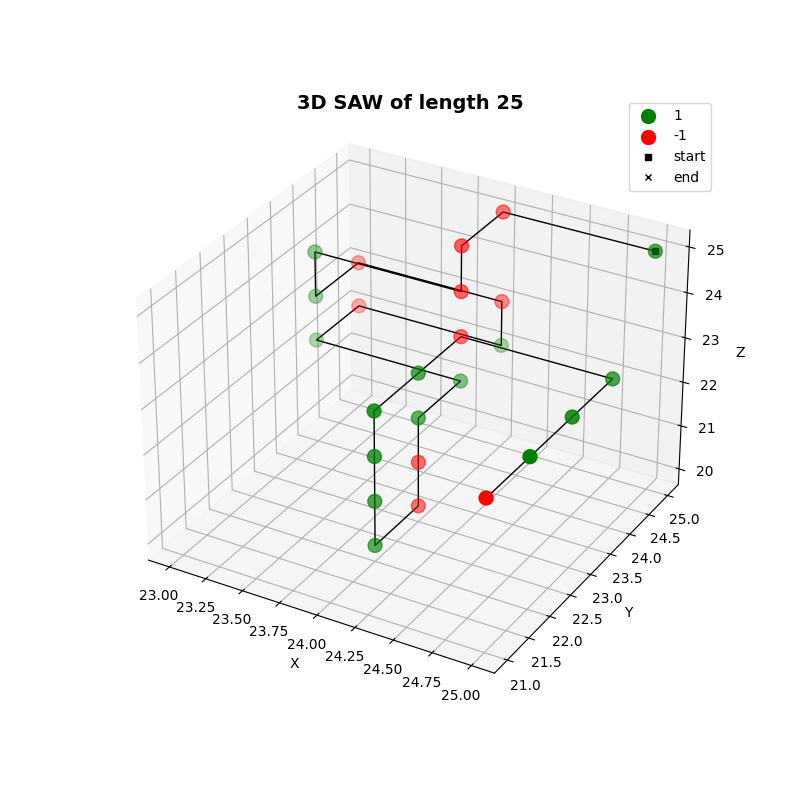

In [91]:
plus_spin_x, plus_spin_y, plus_spin_z = zip(*plus_spin)
min_spin_x, min_spin_y, min_spin_z = zip(*min_spin)
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(x3, y3, z3, color='black', linewidth = 1)
#ax.scatter(x3,y3,z3, 'bo')
ax.scatter(plus_spin_x,plus_spin_y,plus_spin_z,s=100, color='green', label='1')
ax.scatter(min_spin_x,min_spin_y, min_spin_z,s=100,color = 'red', label='-1')
ax.plot(x3[0], y3[0],z3[0], 'ks', ms = 5, label='start')
ax.plot(x3[-1], y3[-1],z3[-1],'kx', ms = 5, label='end')
plt.legend()
plt.title('3D SAW of length ' + str(len(x3)), fontsize=14, fontweight='bold', y = 1.05)
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/SAW_plot_samespin.png', bbox_inches='tight')
plt.show()

In [92]:
print(x3[0],y3[0],z3[0])
print(spins[x3[0],y3[0],z3[0]])

25 25 25
1


### SAW move

In [ ]:
for j in range(0,len(x3)):
    print(j,":",correct_z(x3,y3,z3,j,spins))
possible_points= find_possible_points(x3,y3,z3,spins)

print(possible_points)

In [93]:
metropol_saw(spins, 1, 2)

[array([[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        ...,
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]],
 
        [[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],

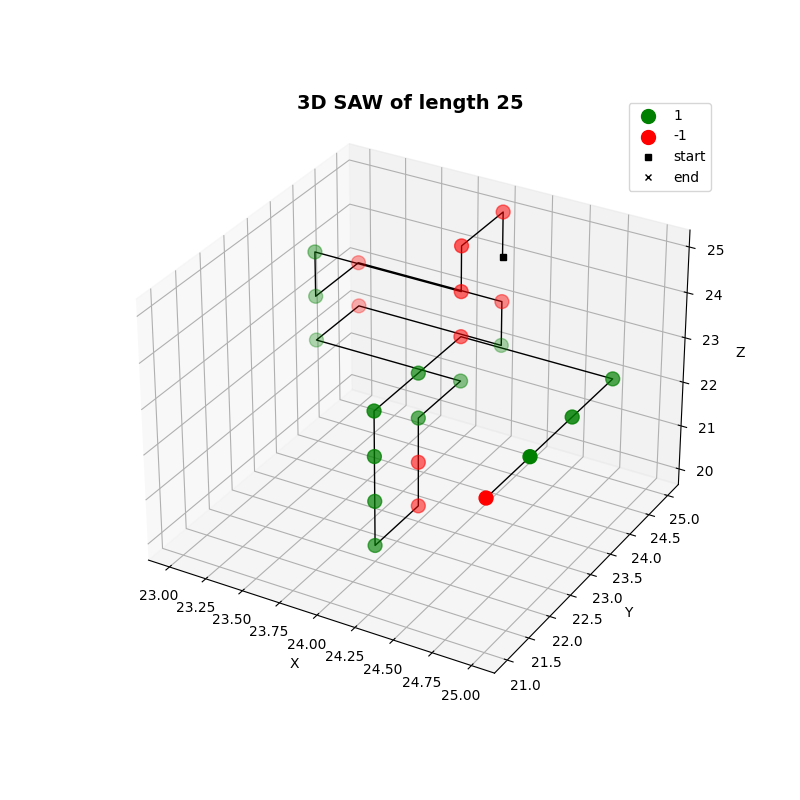

In [94]:
plus_spin, min_spin = plus_min(spins)
plus_spin_x, plus_spin_y, plus_spin_z = zip(*plus_spin)
min_spin_x, min_spin_y, min_spin_z = zip(*min_spin)
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.grid()
ax.plot(x3, y3, z3, color='black', linewidth = 1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
#ax.scatter(x3,y3,z3, 'bo')
ax.scatter(plus_spin_x,plus_spin_y,plus_spin_z,s=100, color='green', label='1')
ax.scatter(min_spin_x,min_spin_y, min_spin_z,s=100,color = 'red', label='-1')
ax.plot(x3[0], y3[0],z3[0], 'ks', ms = 5, label='start')
ax.plot(x3[-1], y3[-1],z3[-1],'kx', ms = 5, label='end')
plt.legend()
plt.title('3D SAW of length ' + str(len(x3)), fontsize=14, fontweight='bold', y = 1.05)
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/SAW_plot_samespin.png', bbox_inches='tight')
plt.show()

In [83]:
print(x3[0],y3[0],z3[0])
print(spins[x3[0],y3[0],z3[0]])

25 25 25
0


## Monte Carlo runs

In [83]:
'''steps and temperature'''
T=2
steps = 10**3

In [ ]:
'''ONLY SAW MOVES'''
#metropol_saw_var_2=mcmove(spins,10**5,T)
metropol_saw_var = metropol_saw(spins, steps,T)
mag_after = metropol_saw_var[1]
energy_after = metropol_saw_var[2]

In [168]:
'''ONLY SPIN MOVES'''
#mag_before = abs(sum(sum(spins)))/len(x)
metropol_spin_var = metropol_spin(spins,steps,T)
mag_after = metropol_spin_var[1]
E_after = metropol_spin_var[2]
#mag_after_2 = mcmove(spins,steps,T)

In [84]:
''' COMBINATION OF SPIN AND SAW MOVES '''
t_b = time.time()
mag_after, energy_after = metropolis_combo(spins,steps,T)
t_e = time.time()
print(t_e-t_b, "s")

509.5069332122803 s


In [85]:
#print(metropol_spin_var)
#print(mag_after)
#print(E_after)

### after mone carlo

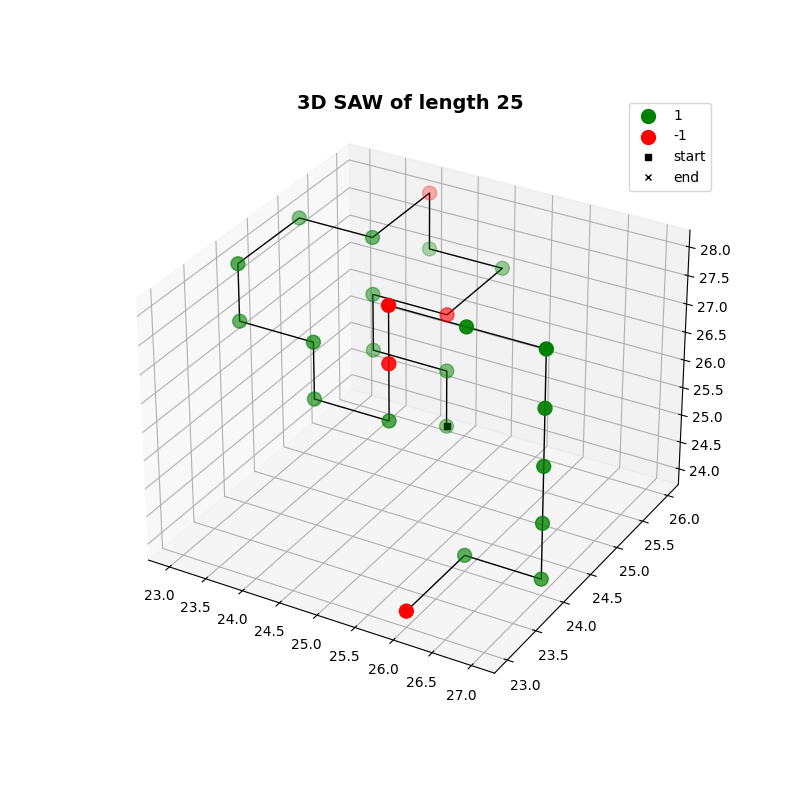

In [86]:
plus_spin, min_spin = plus_min(spins)
plus_spin_x, plus_spin_y, plus_spin_z = zip(*plus_spin)
min_spin_x, min_spin_y, min_spin_z = zip(*min_spin)
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection='3d')
ax.grid()
ax.plot(x3, y3, z3, color='black', linewidth = 1)
#ax.scatter(x3,y3,z3, 'bo')
ax.scatter(plus_spin_x,plus_spin_y,plus_spin_z,s=100, color='green', label='1')
ax.scatter(min_spin_x,min_spin_y, min_spin_z,s=100,color = 'red', label='-1')
ax.plot(x3[0], y3[0],z3[0], 'ks', ms = 5, label='start')
ax.plot(x3[-1], y3[-1],z3[-1],'kx', ms = 5, label='end')
plt.legend()
plt.title('3D SAW of length ' + str(len(x3)), fontsize=14, fontweight='bold', y = 1.05)
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/SAW_plot_samespin.png', bbox_inches='tight')
plt.show()

### Plots

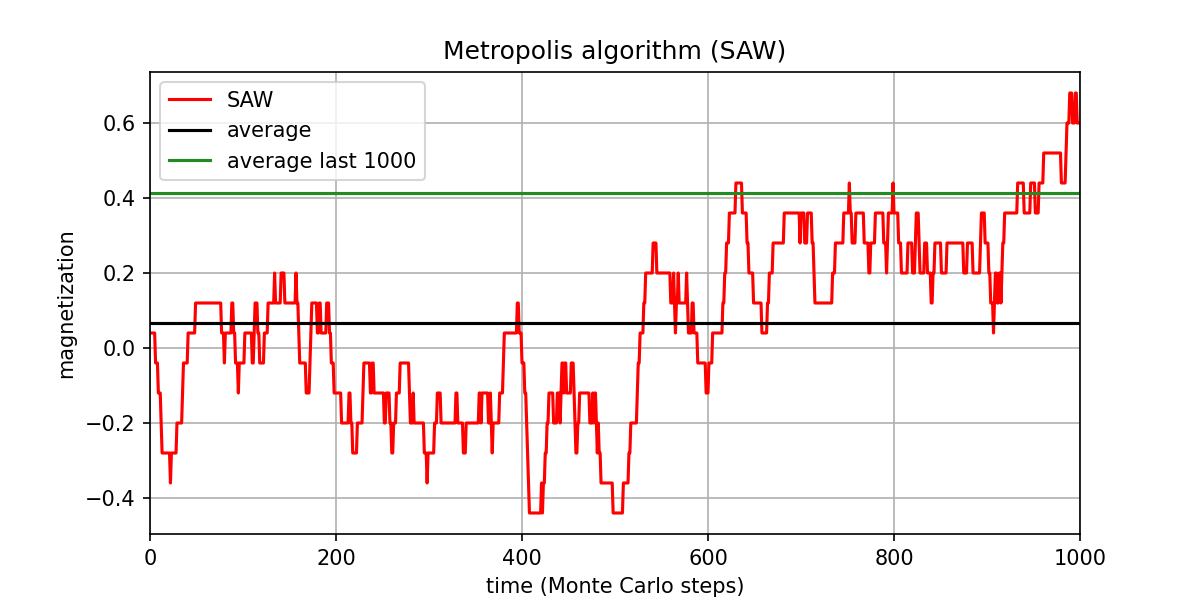

In [87]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Metropolis algorithm (SAW)')
plt.xlabel(('time (Monte Carlo steps)'))
plt.ylabel('magnetization')
plt.grid()
plt.xlim(0,steps)
plt.plot(mag_after, color = 'red', label='SAW')
plt.axhline(np.mean(mag_after),color= 'black', label= 'average')
plt.axhline(np.mean(mag_after[-100:]),color= 'forestgreen', label= 'average last 1000')
#plt.plot(mag_after_2, label='SAW_2')
#plt.axhline(y = mag_exact, label = 'exact')
ax.legend()
#fig.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/metropol_magn.png', bbox_inches = 'tight')

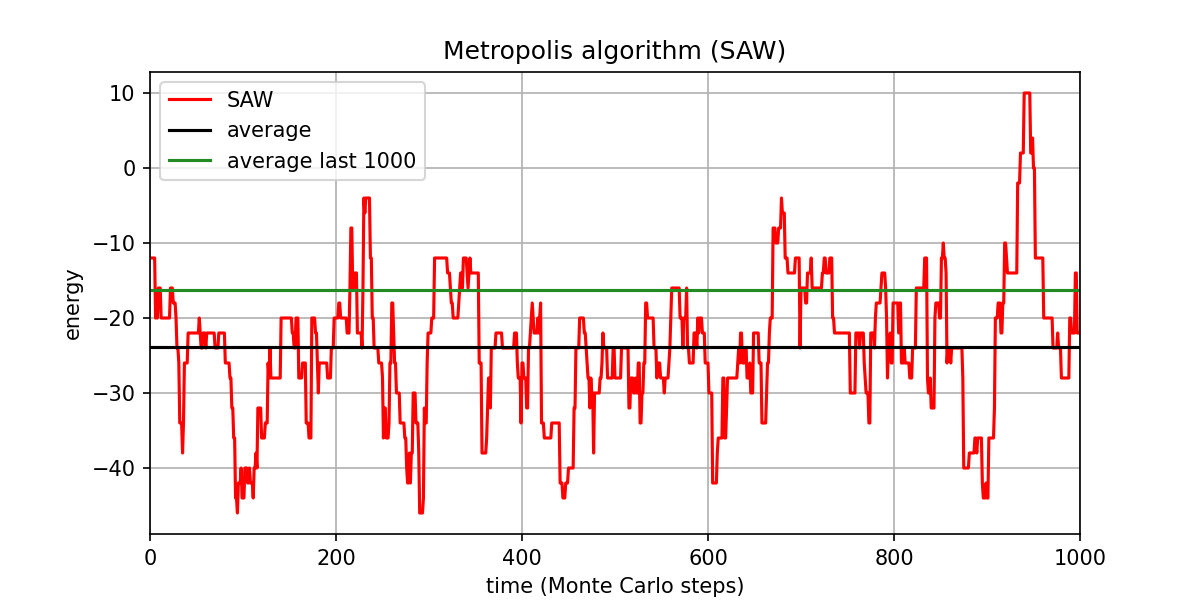

In [88]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Metropolis algorithm (SAW)')
plt.xlabel(('time (Monte Carlo steps)'))
plt.ylabel('energy')
plt.grid()
plt.xlim(0,steps)
plt.plot(energy_after, color = 'red', label='SAW')
plt.axhline(np.mean(energy_after),color= 'black', label= 'average')
plt.axhline(np.mean(energy_after[-100:]),color= 'forestgreen', label= 'average last 1000')
#plt.plot(mag_after_2, label='SAW_2')
#plt.axhline(y = mag_exact, label = 'exact')
ax.legend()
#fig.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/metropol_magn.png', bbox_inches = 'tight')

### relations with T

In [142]:
#T = np.linspace(0.01,100, 50)
T = np.arange(0.1,4,0.1)
mag_T = []
heath_cap = []
E_T = []
ξ = []
for t in np.nditer(T):
    print(t)
    temp_var = metropol_spin(spins,10**3,t)
    heath_cap.append(np.var(temp_var[1])/(t**2*len(x3)))
    E_T.append(np.mean(temp_var[1]))
    mag_T.append(np.mean(temp_var[0]))
    plus_spin, min_spin = plus_min(spins)
    ξ.append(abs(len(plus_spin) - len(min_spin))/len(x3))
    spins = spins_original.copy()
    x3 = x_original.copy()
    y3 = y_original.copy()
    z3 = z_original.copy()
#mag_T = [np.mean(metropolis_combo(spins,10**4,t)[0]) for t in np.nditer(T)]
#np.mean(metropolis_combo(spins,10**3,2)[0])
#plt.plot(T, np.mean(metropolis_combo(spins,10**3,T)[0]))

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3000000000000003
1.4000000000000001
1.5000000000000002
1.6
1.7000000000000002
1.8000000000000003
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5000000000000004
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0000000000000004
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5000000000000004
3.6
3.7
3.8000000000000003
3.9000000000000004


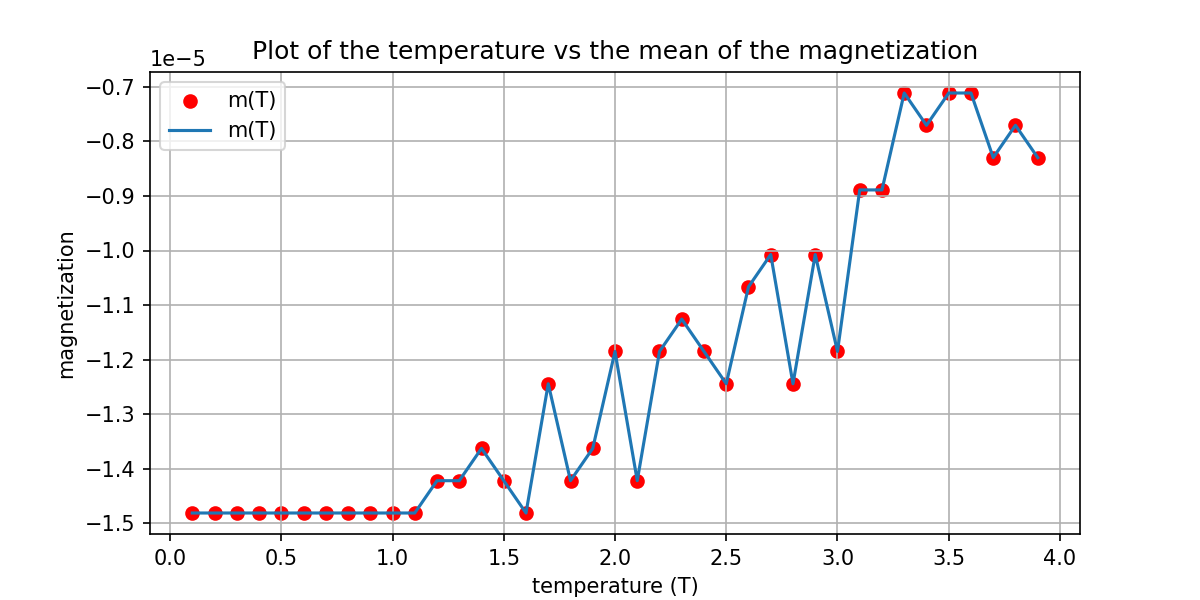

In [143]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Plot of the temperature vs the mean of the magnetization')
plt.xlabel(('temperature (T)'))
plt.ylabel('magnetization')
plt.grid()
#plt.xlim(0,100)
plt.scatter(T,mag_T, color = 'red', label='m(T)')
plt.plot(T,mag_T, label='m(T)')
#plt.plot(x,τ_opt_2/x + τ_opt_2, color= 'blue', label = 'τ/T')
#plt.plot(x,np.exp(-x/τ_opt)+ τ_opt, color= 'darkgreen', label = '$e^{-T/τ}$')
#plt.plot(x,(np.sinh(x*τ_opt_3)+τ_opt_3), color= 'black', label = '$\sinh(T*τ)$')
#plt.plot(T, mag_T, color = 'black', label='SAW')
#plt.ylim(-0.25,0.010)
plt.legend()
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/T_vs_mag.png', bbox_inches='tight')

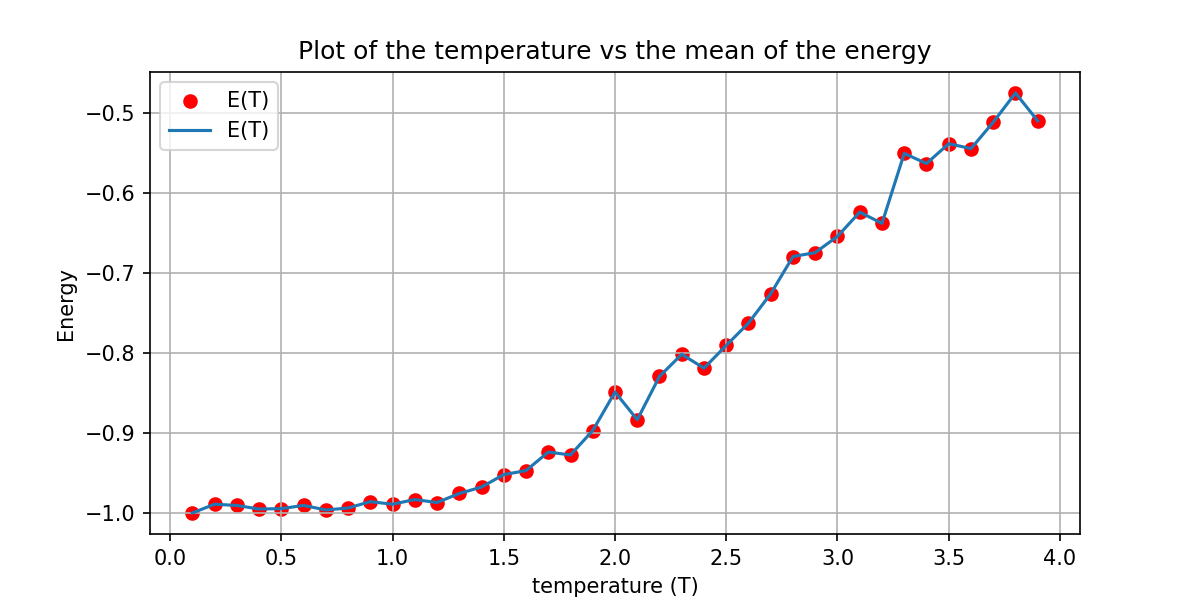

In [144]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Plot of the temperature vs the mean of the energy')
plt.xlabel(('temperature (T)'))
plt.ylabel('Energy')
plt.grid()
#plt.xlim(0,100)
plt.scatter(T,E_T, color = 'red', label='E(T)')
plt.plot(T,E_T, label='E(T)')
#plt.plot(x,τ_opt_2/x + τ_opt_2, color= 'blue', label = 'τ/T')
#plt.plot(x,np.exp(-x/τ_opt)+ τ_opt, color= 'darkgreen', label = '$e^{-T/τ}$')
#plt.plot(x,(np.sinh(x*τ_opt_3)+τ_opt_3), color= 'black', label = '$\sinh(T*τ)$')
#plt.plot(T, mag_T, color = 'black', label='SAW')
#plt.ylim(-0.25,0.010)
plt.legend()
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/T_vs_E.png', bbox_inches='tight')

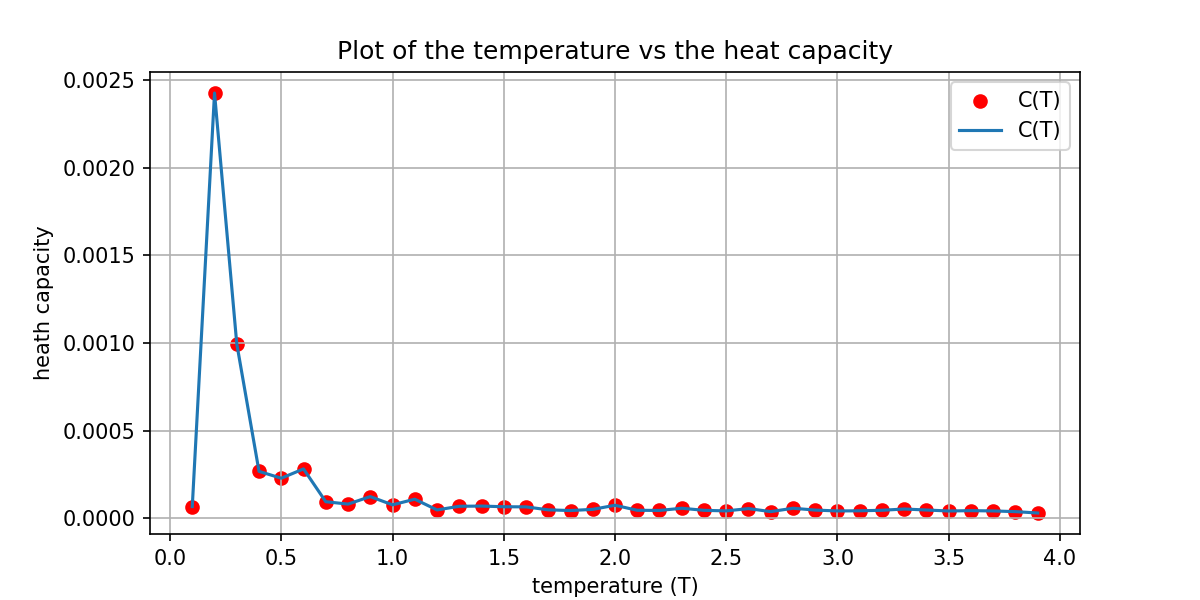

In [145]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Plot of the temperature vs the heat capacity')
plt.xlabel(('temperature (T)'))
plt.ylabel('heath capacity')
plt.grid()
#plt.xlim(0,100)
plt.scatter(T,heath_cap, color = 'red', label='C(T)')
plt.plot(T,heath_cap, label='C(T)')
#plt.plot(x,τ_opt_2/x + τ_opt_2, color= 'blue', label = 'τ/T')
#plt.plot(x,np.exp(-x/τ_opt)+ τ_opt, color= 'darkgreen', label = '$e^{-T/τ}$')
#plt.plot(x,(np.sinh(x*τ_opt_3)+τ_opt_3), color= 'black', label = '$\sinh(T*τ)$')
#plt.plot(T, mag_T, color = 'black', label='SAW')
#plt.ylim(-0.010,0.010)
plt.legend()
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/T_vs_heathcap.png', bbox_inches='tight')

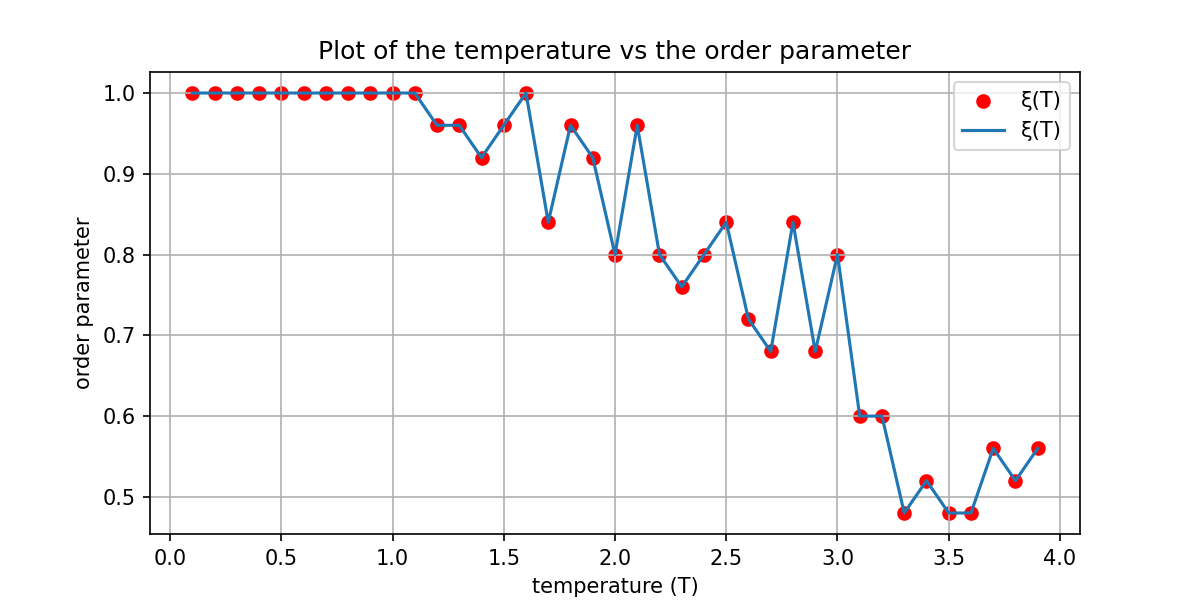

In [146]:
fig, ax = plt.subplots(1,1, dpi=150, figsize=(8, 4))
plt.title('Plot of the temperature vs the order parameter')
plt.xlabel(('temperature (T)'))
plt.ylabel('order parameter')
plt.grid()
#plt.xlim(0,100)
plt.scatter(T,ξ, color = 'red', label='ξ(T)')
plt.plot(T,ξ, label='ξ(T)')
#plt.plot(x,τ_opt_2/x + τ_opt_2, color= 'blue', label = 'τ/T')
#plt.plot(x,np.exp(-x/τ_opt)+ τ_opt, color= 'darkgreen', label = '$e^{-T/τ}$')
#plt.plot(x,(np.sinh(x*τ_opt_3)+τ_opt_3), color= 'black', label = '$\sinh(T*τ)$')
#plt.plot(T, mag_T, color = 'black', label='SAW')
#plt.ylim(-0.025,0.10)
plt.legend()
#plt.savefig('/home/sander/Documents/School/univ/Fysica/master/fase_3/thesis/notes/notes/Pictures/T_vs_order.png', bbox_inches='tight')